In [116]:
import geopandas as gpd

from gensim.matutils import corpus2csc
from gensim.corpora import Dictionary
from gensim.models import Word2Vec


import pickle

from importlib import reload
import ppmi_svd

import matplotlib.pyplot as plt

import nltk
import json
import requests

In [46]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (4.45, 3)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff", dpi=600)
    fig.savefig("../figures/" + fig_name + ".png", dpi=600)

In [89]:
GIST = gpd.read_parquet("../data/large_files/GIST_geocontexts.parquet")
len(GIST)

106898

In [90]:
ids_lines = pickle.load(open("../data/ids_lines.pickle", "rb"))
freqs_tups = pickle.load(open("../data/freqs_tups.pickle", "rb"))

In [91]:
religion_final = ["θεός", "Ζεύς", "εὐσεβής", 'ἱερός']
morality_final = ["ἀγαθός", "ἀρετή", "δικαίως", "φίλος"]

In [92]:
N_types_covered = 1000
vocab = [tup[0] for tup in freqs_tups[:N_types_covered]]
dictionary = Dictionary([vocab])

In [93]:
dictionary.doc2bow(["θεός", "θεός","Ζεύς", "nonexistent", "εὐσέβεια", 'ἱερεύς', "θυσία"])

[(35, 1), (294, 2), (300, 1), (931, 1)]

In [94]:
dictionary[294]

'θεός'

In [95]:
class NgramCorpusBows:
    def __iter__(self):
        with open("../data/large_files/corpus_ngrams.txt", "r") as f:
            lines = f.readlines()
            for phi_id in ids_list:
                for line in lines[ids_lines[phi_id][0] : ids_lines[phi_id][1]]:
                    bow = dictionary.doc2bow(line.split())
                    yield bow

In [96]:
ids_list = GIST[GIST["random_dates"].apply(lambda x: -500 < x[0] < -401)]["PHI_ID"].astype("str").tolist()
len(ids_list)

6707

In [97]:
cent_ids_samples = {}
for cent in range(-6, 4):
    if cent < 0:
        cent_start, cent_end = cent * 100, cent * 100 + 99
    else:
        cent_start, cent_end = cent * 100 + 1, cent * 100 + 100
    subset_ids = GIST[GIST["random_dates"].apply(lambda x: cent_start < x[0] < cent_end)]["PHI_ID"]
    subset_sample_ids = subset_ids.sample(5000, replace=True)
    cent_ids_samples[cent] = subset_sample_ids

In [98]:
# full_model
ids_list = []
for cent in cent_ids_samples.keys():
    ids_list.extend(list(cent_ids_samples[cent]))
ids_list = [str(id) for id in ids_list]

In [99]:
len(ids_list)

50000

In [100]:
corpus = NgramCorpusBows()

In [101]:
%%time
cooc, vocabulary, pmi_matrix, keyed_vectors, pmi_svd_cos = ppmi_svd.from_bows_to_embeddings(corpus, dictionary)

CPU times: user 50.2 s, sys: 1.38 s, total: 51.6 s
Wall time: 30 s


In [102]:
keyed_vectors.most_similar("θεός", topn=100)

[('πᾶς', 0.9858776926994324),
 ('δῆμος', 0.9761057496070862),
 ('ἱερός', 0.9729395508766174),
 ('ἀνήρ', 0.9694532752037048),
 ('ἄρχων', 0.9694083333015442),
 ('ἔτος', 0.9659378528594971),
 ('γίγνομαι', 0.9655322432518005),
 ('βουλή', 0.9651075005531311),
 ('ἔχω', 0.9574875831604004),
 ('ἀγαθός', 0.9573871493339539),
 ('παῖς', 0.9573367834091187),
 ('μείς', 0.9571022391319275),
 ('ἱερεύς', 0.9540607333183289),
 ('υἱός', 0.9480600357055664),
 ('δίδωμι', 0.9457157254219055),
 ('πατήρ', 0.9452864527702332),
 ('Ἀπολλωνία', 0.9426635503768921),
 ('Ἀσκληπιός', 0.941089391708374),
 ('γυνή', 0.9389791488647461),
 ('ἀνατίθημι', 0.9385998845100403),
 ('Ζεύς', 0.9317079782485962),
 ('ποιέω', 0.9274541139602661),
 ('βασιλεύς', 0.9259136319160461),
 ('τιμή', 0.9175242185592651),
 ('καλός', 0.9108782410621643),
 ('μέλει', 0.9061900973320007),
 ('πράσσω', 0.905220091342926),
 ('νόμος', 0.9031177759170532),
 ('Ἀθῆναι', 0.9013820886611938),
 ('δέω', 0.9010432958602905),
 ('λέγω', 0.8998599648475647),
 (

# Explore visually..

In [103]:
reload(ppmi_svd)

<module 'ppmi_svd' from '/Users/kasev/Projects/EpiMR/scripts/ppmi_svd.py'>

In [104]:
xs, ys, words = ppmi_svd.get_tsne_coors(keyed_vectors, perplexity=15)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [110]:
word_color_dict = {}
for word in words:
    if word in religion_final:
        word_color_dict[word] = "darkgreen"
    elif word in morality_final:
        word_color_dict[word] = "darkred"
    else:
        word_color_dict[word] = "grey"

(0.0, 1.0, 0.0, 1.0)

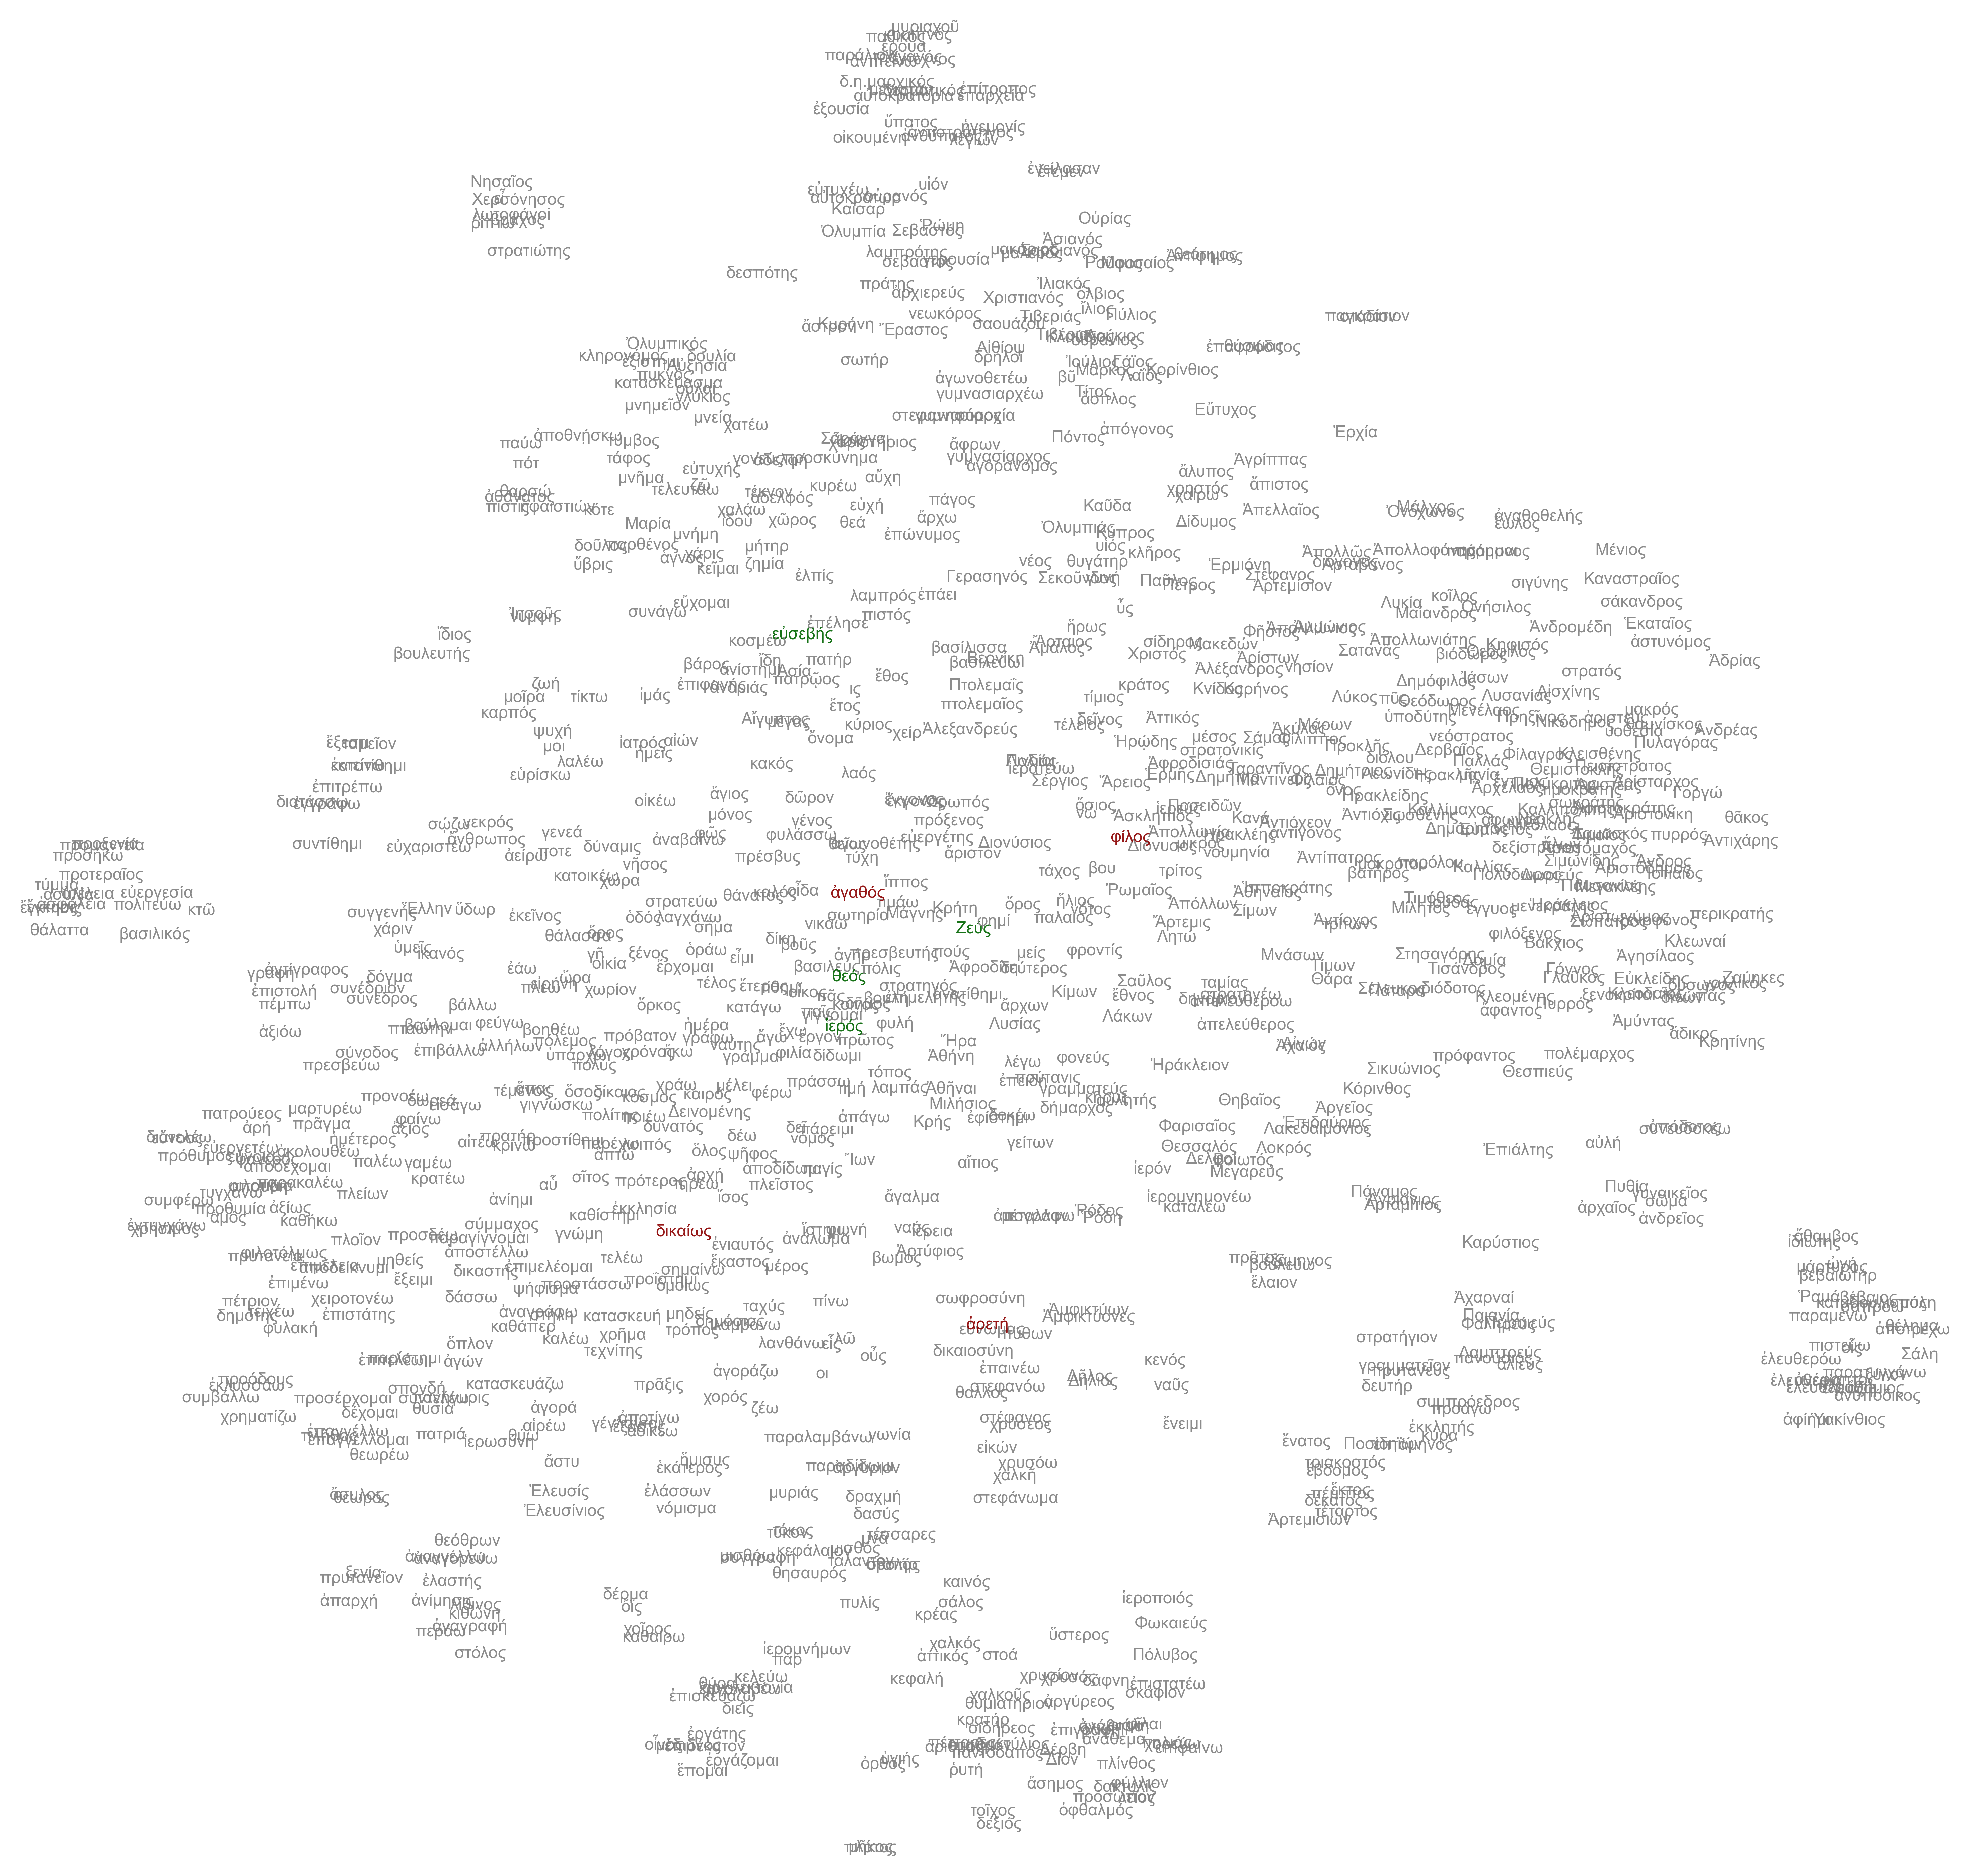

In [111]:
fig, ax = plt.subplots(1,1, figsize=(12,12), dpi=600, frameon=False)
cutoff = 0
border = 0
for x, y, word in zip(xs, ys, words):
    if (cutoff <= x <= 1-cutoff) and (cutoff <= y <= 1-cutoff):
        ax.text(x, y, word, horizontalalignment='center', color=word_color_dict[word], alpha=0.9, fontsize=6)#fontsize=word_size_dict[word], color=word_color_dict[word], alpha=0.9)
ax.set_xlim(cutoff-border, 1-cutoff+border)
ax.set_ylim(cutoff-border, 1-cutoff+border)
#ax.set_facecolor("#F2F5FA")
ax.axis("off")
#ax.add_artist(ax.patch)
#ax.patch.set_zorder(-1)

In [112]:
fig.savefig("../figures/full_model_ppmisvd_large.png")

In [113]:
class NgramCorpus:
    def __iter__(self):
        with open("../data/large_files/corpus_ngrams.txt", "r") as f:
            lines = f.readlines()
            for phi_id in ids_list:
                for line in lines[ids_lines[phi_id][0] : ids_lines[phi_id][1]]:
                    yield line.split()

In [115]:
len(ids_list)

50000

In [117]:
corpus = NgramCorpus()

In [121]:
corpus_len = len([doc for doc in corpus])

In [118]:
model = Word2Vec(vector_size=150, window=3, negative=5, ns_exponent=1, sg=0, epochs=10, workers=8)

In [120]:
model.build_vocab_from_freq(word_freq=dict(freqs_tups[:N_types_covered]))

In [122]:
model.train(corpus, total_examples=corpus_len, epochs=model.epochs)

(29809124, 60827810)

In [123]:
keyed_vectors_w2v = model.wv

In [124]:
xs, ys, words = ppmi_svd.get_tsne_coors(keyed_vectors_w2v, perplexity=15)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(0.0, 1.0, 0.0, 1.0)

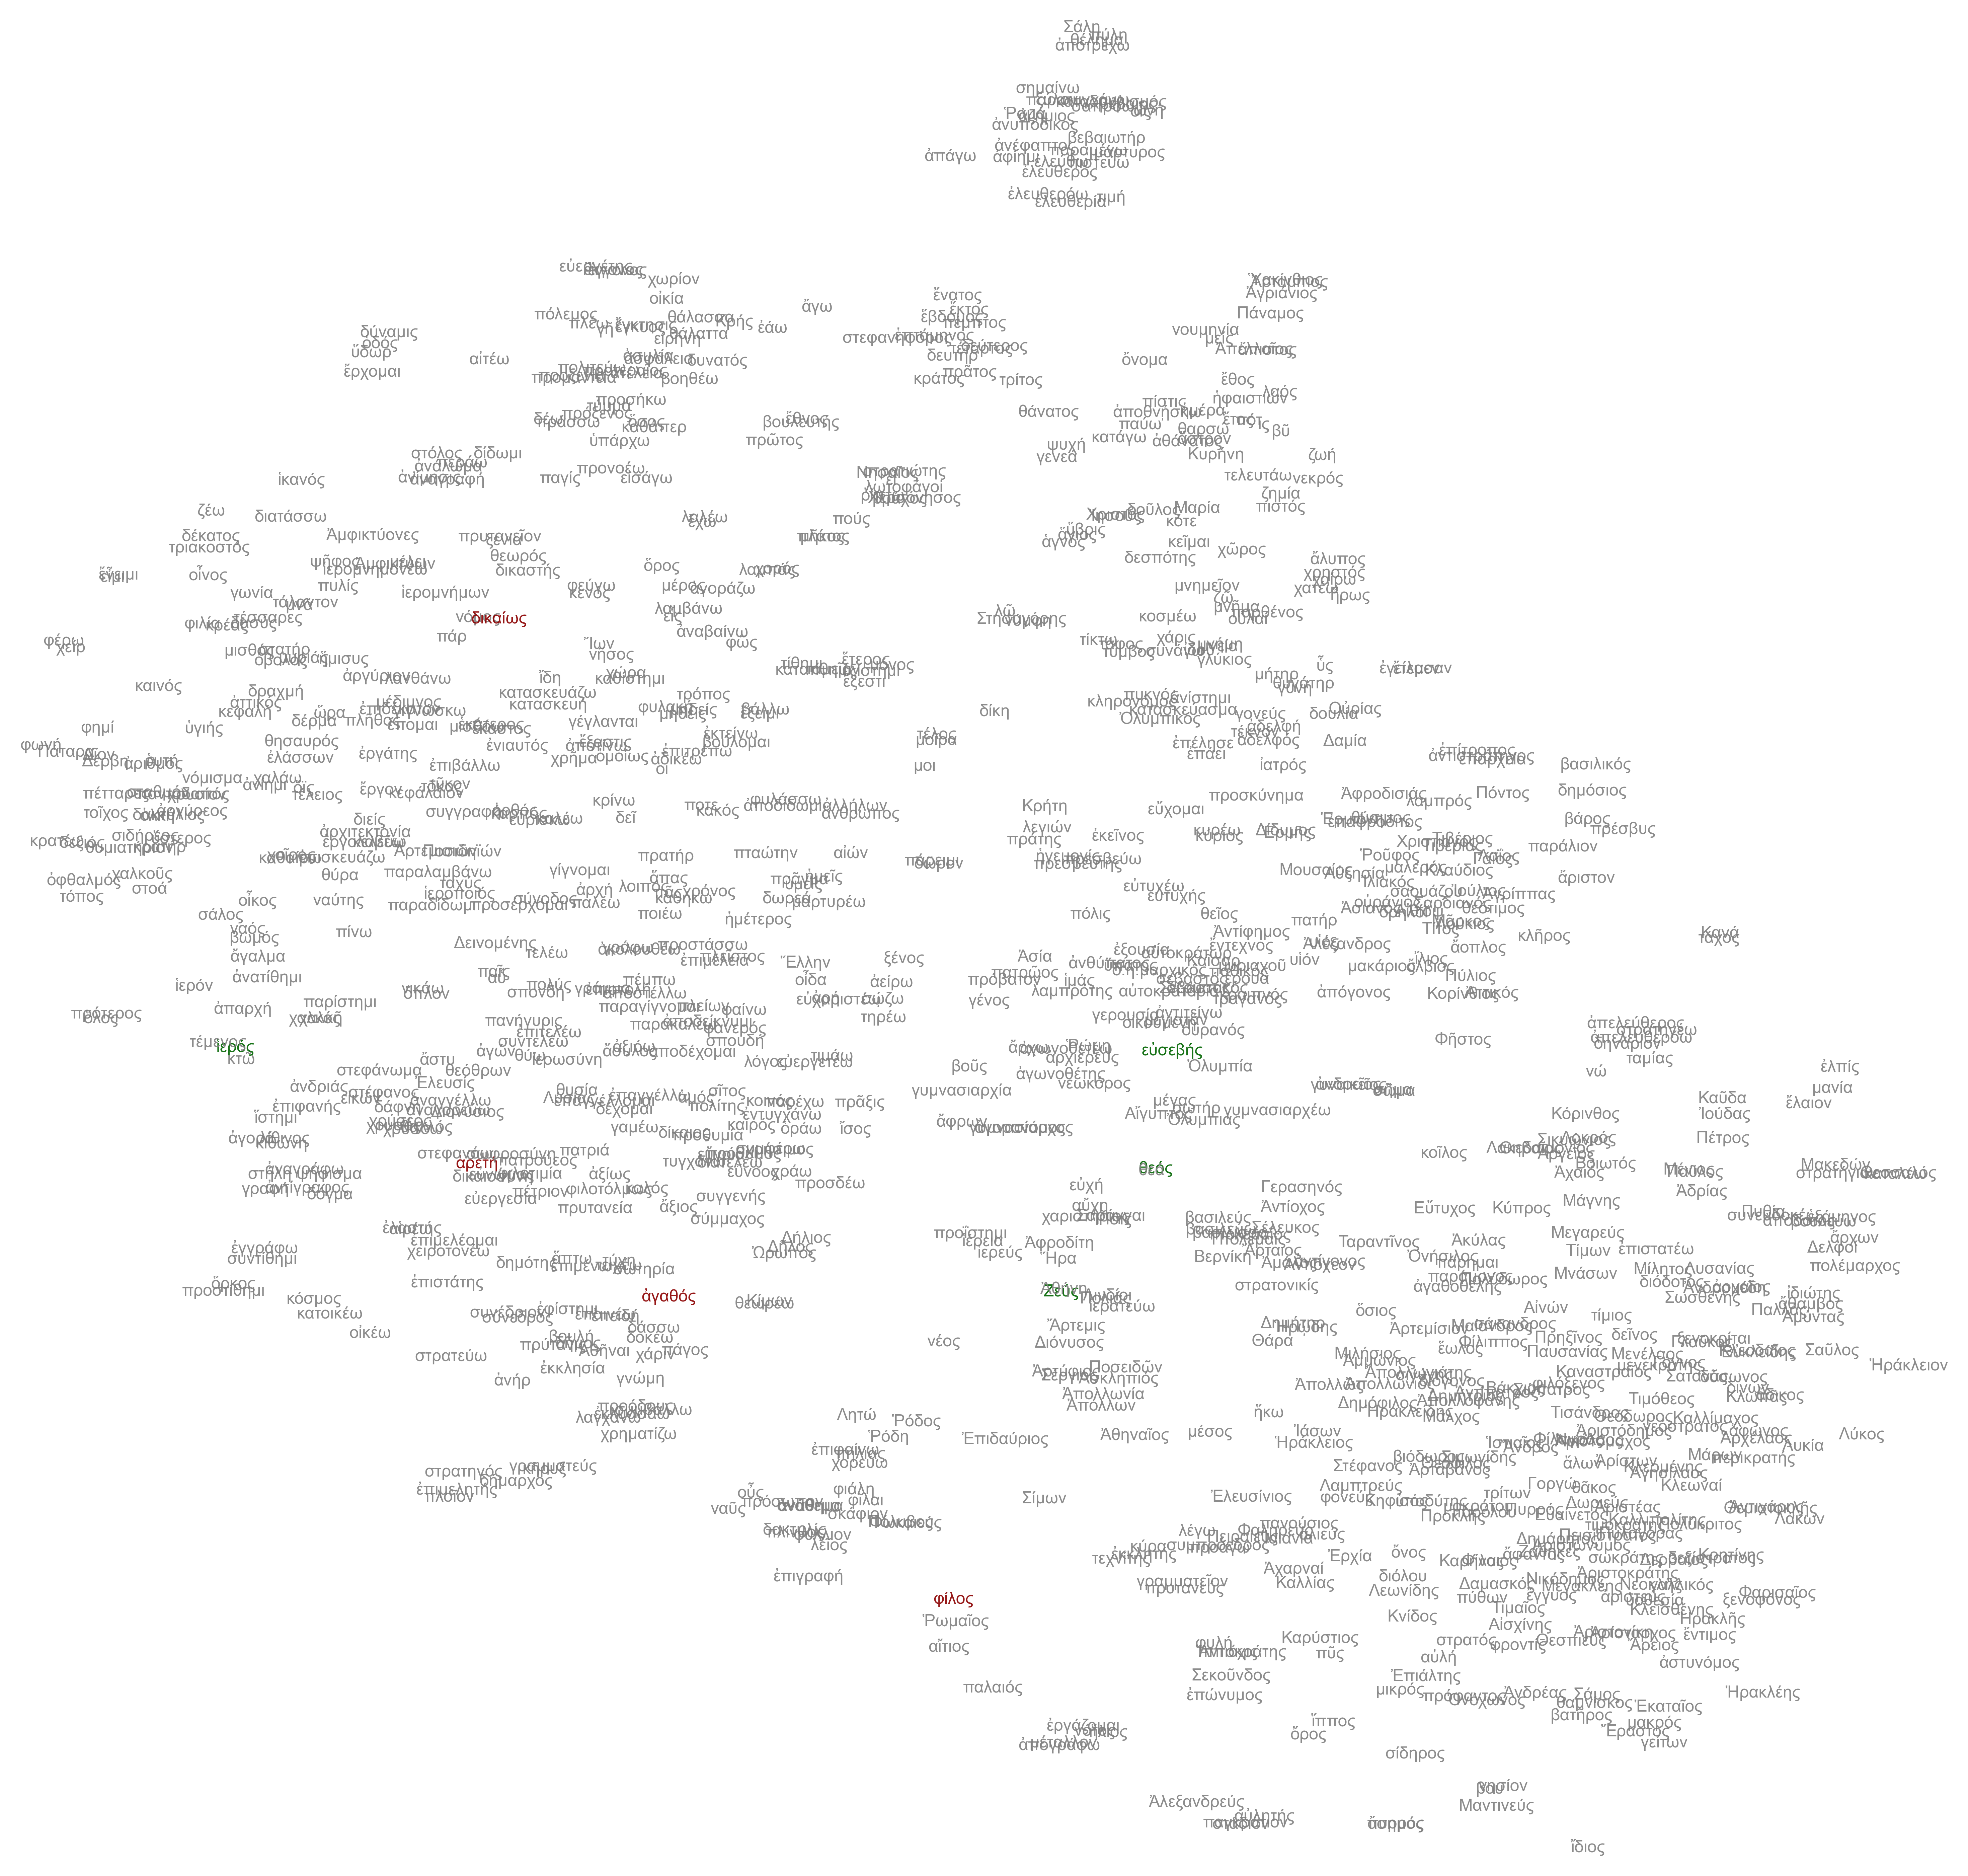

In [125]:
fig, ax = plt.subplots(1,1, figsize=(12,12), dpi=600, frameon=False)
cutoff = 0
border = 0
for x, y, word in zip(xs, ys, words):
    if (cutoff <= x <= 1-cutoff) and (cutoff <= y <= 1-cutoff):
        ax.text(x, y, word, horizontalalignment='center', color=word_color_dict[word], alpha=0.9, fontsize=6)#fontsize=word_size_dict[word], color=word_color_dict[word], alpha=0.9)
ax.set_xlim(cutoff-border, 1-cutoff+border)
ax.set_ylim(cutoff-border, 1-cutoff+border)
ax.axis("off")

In [126]:
fig.savefig("../figures/full_model_word2vec_large.png")